In [1]:
import os
import glob
import segyio
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load the datasets
unknown1 = pd.read_csv('unknown1_litho.csv')
unknown1.dropna(inplace = True)
unknown2 = pd.read_csv('unknown2_litho.csv')
unknown2.dropna(inplace = True)


In [3]:
unknown1 = unknown1[['Time (s)','Amplitude','Instantaneous_freq','Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]
unknown2 = unknown2[['Time (s)','Amplitude','Instantaneous_freq','Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


In [4]:
# Folder path
folder_path = r'C:\Users\sushila\Desktop\Hackathon'

# Use glob to find all files that contain 'TEMP.csv' in the name
files = glob.glob(os.path.join(folder_path, '*SW.csv'))

# List to store data from each file
data_frames = []

# Loop through each file and read it
for file in files:
    # Extract the part of the filename before 'TEMP'
    file_name = os.path.basename(file)
    file_prefix = file_name.split('_SW')[0]
    
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the file prefix
    df['holeid'] = file_prefix
    
    # Append the DataFrame to the list
    data_frames.append(df)

# If you want to combine all the data into a single DataFrame
combined_data = pd.concat(data_frames, ignore_index=True)

#Roundoff the depth so that it can be easily compared with depth from another dataframe
combined_data['Depth'] = combined_data['Depth'].round(1)
combined_data

,Time (s),Depth,SW,Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy,holeid
0,0.935,1495.8,1.0,1799.174805,29.020841,1799.174805,2959.239209,3.237030e+06,REZOVACCKE_KRCCEVINE_1
1,0.936,1497.5,1.0,1181.547852,29.272842,1181.547852,2416.801758,1.396055e+06,REZOVACCKE_KRCCEVINE_1
2,0.937,1499.2,1.0,590.774170,29.735466,590.774170,1804.545459,3.490141e+05,REZOVACCKE_KRCCEVINE_1
3,0.960,1538.2,1.0,-751.892578,41.107193,751.892578,1047.281201,5.653424e+05,REZOVACCKE_KRCCEVINE_1
4,0.961,1540.0,1.0,-1557.493164,39.599785,1557.493164,252.422217,2.425785e+06,REZOVACCKE_KRCCEVINE_1
...,...,...,...,...,...,...,...,...,...
1435,1.328,3344.5,1.0,3098.796875,21.348782,3098.796875,1311.030273,9.602542e+06,VIROVITICA_3ALFA
1436,1.329,3347.1,1.0,4469.416992,21.424767,4469.416992,2300.260937,1.997569e+07,VIROVITICA_3ALFA
1437,1.330,3349.7,1.0,5840.037109,21.500752,5840.037109,3384.838965,3.410603e+07,VIROVITICA_3ALFA
1438,1.331,3352.2,1.0,7210.657227,21.576738,7210.657227,4564.764355,5.199358e+07,VIROVITICA_3ALFA


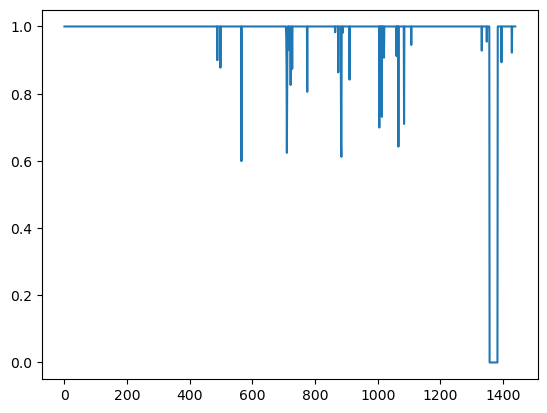

In [5]:
plt.plot(combined_data['SW'])

In [5]:
litho_data = pd.read_csv('resampled_litho_data.csv')
litho_data

,holeid,Depth,Lithology,Strat_Simplified_Viro,Lithology_label,Strat_Simplified_Viro_label
0,VIROVITICA_1,0.0,humus and sand,QUATERNARY,14,9
1,VIROVITICA_1,0.1,humus and sand,QUATERNARY,14,9
2,VIROVITICA_1,0.2,humus and sand,QUATERNARY,14,9
3,VIROVITICA_1,0.3,humus and sand,QUATERNARY,14,9
4,VIROVITICA_1,0.4,humus and sand,QUATERNARY,14,9
...,...,...,...,...,...,...
216400,REZOVACCKE_KRCCEVINE_2,4553.5,siltstone and sandstone,TERTIARY BASEMENT,26,11
216401,REZOVACCKE_KRCCEVINE_2,4553.6,siltstone and sandstone,TERTIARY BASEMENT,26,11
216402,REZOVACCKE_KRCCEVINE_2,4553.7,siltstone and sandstone,TERTIARY BASEMENT,26,11
216403,REZOVACCKE_KRCCEVINE_2,4553.8,siltstone and sandstone,TERTIARY BASEMENT,26,11


In [6]:
# Sort both dataframes by 'holeid' and 'Depth'
combined_data = combined_data.sort_values(by=['holeid', 'Depth'])
litho_data = litho_data.sort_values(by=['holeid', 'Depth'])

# Merge the two dataframes on 'holeid' and 'Depth' to find exact matches
exact_match_data = pd.merge(combined_data, litho_data[['holeid', 'Depth', 'Lithology_label', 'Strat_Simplified_Viro_label']], 
                            on=['holeid', 'Depth'], how='inner')

# Check how many rows had exact depth matches
print(f"Number of exact depth matches: {exact_match_data.shape[0]}")

# Display the first few rows of the exact match data
exact_match_data


Number of exact depth matches: 1440


,Time (s),Depth,SW,Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy,holeid,Lithology_label,Strat_Simplified_Viro_label
0,0.935,1495.8,1.0,1799.174805,29.020841,1799.174805,2959.239209,3.237030e+06,REZOVACCKE_KRCCEVINE_1,7,3
1,0.936,1497.5,1.0,1181.547852,29.272842,1181.547852,2416.801758,1.396055e+06,REZOVACCKE_KRCCEVINE_1,7,3
2,0.937,1499.2,1.0,590.774170,29.735466,590.774170,1804.545459,3.490141e+05,REZOVACCKE_KRCCEVINE_1,7,3
3,0.960,1538.2,1.0,-751.892578,41.107193,751.892578,1047.281201,5.653424e+05,REZOVACCKE_KRCCEVINE_1,7,3
4,0.961,1540.0,1.0,-1557.493164,39.599785,1557.493164,252.422217,2.425785e+06,REZOVACCKE_KRCCEVINE_1,7,3
...,...,...,...,...,...,...,...,...,...,...,...
1435,1.328,3344.5,1.0,3098.796875,21.348782,3098.796875,1311.030273,9.602542e+06,VIROVITICA_3ALFA,22,7
1436,1.329,3347.1,1.0,4469.416992,21.424767,4469.416992,2300.260937,1.997569e+07,VIROVITICA_3ALFA,22,7
1437,1.330,3349.7,1.0,5840.037109,21.500752,5840.037109,3384.838965,3.410603e+07,VIROVITICA_3ALFA,22,7
1438,1.331,3352.2,1.0,7210.657227,21.576738,7210.657227,4564.764355,5.199358e+07,VIROVITICA_3ALFA,22,7


In [7]:

from sklearn.model_selection import train_test_split

X = exact_match_data[['Time (s)','Amplitude','Instantaneous_freq', 'Amplitude_abs','Amplitude_roll_mean','Amplitude_energy','Strat_Simplified_Viro_label']]


# Target variable is 'PHI'
y = exact_match_data['SW']

#

In [8]:
X

,Time (s),Amplitude,Instantaneous_freq,Amplitude_abs,Amplitude_roll_mean,Amplitude_energy,Strat_Simplified_Viro_label
0,0.935,1799.174805,29.020841,1799.174805,2959.239209,3.237030e+06,3
1,0.936,1181.547852,29.272842,1181.547852,2416.801758,1.396055e+06,3
2,0.937,590.774170,29.735466,590.774170,1804.545459,3.490141e+05,3
3,0.960,-751.892578,41.107193,751.892578,1047.281201,5.653424e+05,3
4,0.961,-1557.493164,39.599785,1557.493164,252.422217,2.425785e+06,3
...,...,...,...,...,...,...,...
1435,1.328,3098.796875,21.348782,3098.796875,1311.030273,9.602542e+06,7
1436,1.329,4469.416992,21.424767,4469.416992,2300.260937,1.997569e+07,7
1437,1.330,5840.037109,21.500752,5840.037109,3384.838965,3.410603e+07,7
1438,1.331,7210.657227,21.576738,7210.657227,4564.764355,5.199358e+07,7


In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
# Ensure reproducibility
RANDOM_STATE = 42


# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(random_state=RANDOM_STATE),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "XGBoost Regressor": XGBRegressor(random_state=RANDOM_STATE),
    "LightGBM Regressor": LGBMRegressor(random_state=RANDOM_STATE),
    "CatBoost Regressor": CatBoostRegressor(verbose=0, random_state=RANDOM_STATE),
}

# Standardize features where necessary
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize results dictionary
results = {}



# Initialize variables to store the best model
best_model_name = None
best_model = None
best_r2_score = -float('inf')  # Initialize with a very low value

# Train, cross-validate, and evaluate models
for model_name, model in models.items():
    print(f"\nTraining {model_name} with Cross-Validation (CV=5)...")
    
    # Use scaled data for Neural Networks and Linear Regression
    if model_name in ["Linear Regression", "Neural Network Regressor"]:
        X_train_fold, X_test_fold = X_train_scaled, X_test_scaled
    else:
        X_train_fold, X_test_fold = X_train, X_test

    # Cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = cross_val_score(
        model, X_train_fold, y_train, cv=cv, scoring="neg_mean_squared_error"
    )

    # Train the model on the full training set
    model.fit(X_train_fold, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_fold)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        "CV Mean Squared Error": -cv_scores.mean(),
        "Test Mean Absolute Error": mae,
        "Test Mean Squared Error": mse,
        "R^2 Score": r2,
    }

    # Print evaluation metrics
    print(f"Cross-Validation Mean Squared Error (CV=5): {-cv_scores.mean():.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    # Update best model based on R^2 score
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model_name = model_name
        best_model = model

# Save the best model
joblib.dump(best_model, "best_model_SW.pkl")



Training Linear Regression with Cross-Validation (CV=5)...
Cross-Validation Mean Squared Error (CV=5): 0.0154
Mean Absolute Error: 0.0534
Mean Squared Error: 0.0113
R^2 Score: 0.1813

Training Random Forest Regressor with Cross-Validation (CV=5)...
Cross-Validation Mean Squared Error (CV=5): 0.0051
Mean Absolute Error: 0.0095
Mean Squared Error: 0.0011
R^2 Score: 0.9191

Training Gradient Boosting Regressor with Cross-Validation (CV=5)...
Cross-Validation Mean Squared Error (CV=5): 0.0043
Mean Absolute Error: 0.0065
Mean Squared Error: 0.0005
R^2 Score: 0.9622

Training XGBoost Regressor with Cross-Validation (CV=5)...
Cross-Validation Mean Squared Error (CV=5): 0.0048
Mean Absolute Error: 0.0065
Mean Squared Error: 0.0009
R^2 Score: 0.9365

Training LightGBM Regressor with Cross-Validation (CV=5)...
Cross-Validation Mean Squared Error (CV=5): 0.0040
Mean Absolute Error: 0.0111
Mean Squared Error: 0.0006
R^2 Score: 0.9552

Training CatBoost Regressor with Cross-Validation (CV=5)...
Cr

['best_model_SW.pkl']

In [10]:
# Load the best model
best_model = joblib.load("best_model_SW.pkl")


# Standardize the features for Neural Networks and Linear Regression
X_unknown1_scaled = scaler.transform(unknown1)
X_unknown2_scaled = scaler.transform(unknown2)

# Predict using the best model
y_unknown1_pred = best_model.predict(X_unknown1_scaled)  # Prediction for unknown1
y_unknown2_pred = best_model.predict(X_unknown2_scaled)  # Prediction for unknown2

# You can now add these predictions back into the unknown datasets
unknown1['SW'] = y_unknown1_pred
unknown2['SW'] = y_unknown2_pred

# Display the predictions
print("\nPredictions for unknown1:")
print(unknown1[['SW']])

print("\nPredictions for unknown2:")
print(unknown2[['SW']])



Predictions for unknown1:
            SW
1     0.964809
2     0.964809
3     0.964809
4     0.964809
5     0.964809
...        ...
1121  0.944635
1122  0.944635
1123  0.944856
1124  0.944635
1125  0.944635

[1125 rows x 1 columns]

Predictions for unknown2:
            SW
1     0.964809
2     0.964809
3     0.964809
4     0.964809
5     0.964809
...        ...
1246  0.944635
1247  0.944635
1248  0.944635
1249  0.944635
1250  0.944635

[1250 rows x 1 columns]


C:\Users\sushila\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
C:\Users\sushila\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


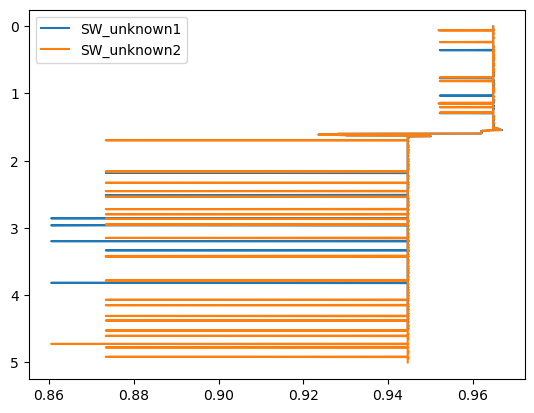

In [11]:
plt.plot(unknown1['SW'], unknown1['Time (s)'], label='SW_unknown1')
plt.plot(unknown2['SW'], unknown2['Time (s)'], label='SW_unknown2')
plt.gca().invert_yaxis()
# Show legend
plt.legend()
plt.show()


In [12]:
# Load the datasets
unknown1 = pd.read_csv('unknown1_litho.csv')
unknown2 = pd.read_csv('unknown2_litho.csv')

# Initialize the TEMP column with NaN values
unknown1['SW'] = np.nan
unknown2['SW'] = np.nan

# Insert predictions from the second row onward (ensure the length matches)
unknown1.loc[1:, 'SW'] = y_unknown1_pred
unknown2.loc[1:, 'SW'] = y_unknown2_pred

# Save the updated DataFrame back to the same CSV file
unknown1.to_csv('unknown1_litho.csv', index=False)
unknown2.to_csv('unknown2_litho.csv', index=False)
